In [2]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

import MSM_methods

import utility_v1
import propagators_v2
import energy_landscapes_v1

import parallel_simulations_v2
import weighted_ensemble_v2
import metadynamics_v1
import multiple_walker_metadynamics_v2
import we_mtd_v1

import visualization_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

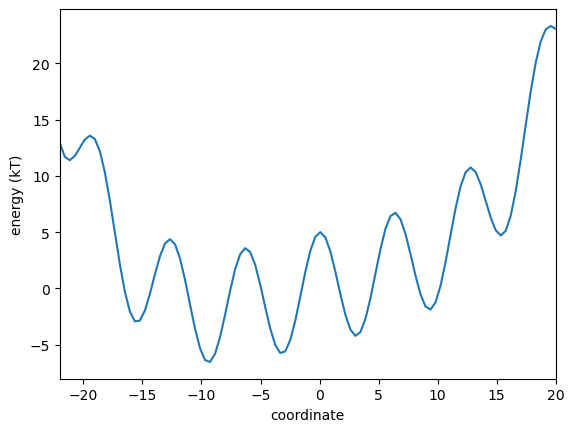

In [3]:
# kT = 1
# dt = 0.01

# importlib.reload(energy_landscapes_v1)

system1 = energy_landscapes_v1.deep_sine_well()
system1.plot_quantity(system1.potential)
plt.xlabel("coordinate")
plt.ylabel("energy (kT)")
plt.xlim(-22, 20)
plt.savefig("figures/deep_sine_well.png", dpi=600)
# system1.plot_quantity(system1.F)
# plt.show()

bootstrap round 1



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 256 parallel multiple walker metadynamics simulations
molecular time: 100000 steps;  aggregate time: 25600000 steps
data points saved: 256000 at 100-step intervals
gaussians of height 0.000390625 are added every 100 steps
9.999999999999948 of 100
0.00390624999999998
20.000000000000004of 100
0.003906250000000001
29.999999999999986of 100
0.0039062499999999983
39.99999999999994 of 100
0.0039062499999999905
49.99999999999993 of 100
0.0039062499999999944
60.00000000000004 of 100
0.003906250000000003
69.99999999999983 of 100
0.0039062499999999905
79.99999999999937 of 100
0.0039062499999999696
89.99999999999929 of 100
0.0039062499999999653
99.999999999999690 of 100
0.003906249999999988
109.99999999999972 of 100
0.00390624999999999
119.99999999999994 of 100
0.0039062499999999983
130.00000000000023 of 100
0.003906250000000006
140.00000000000034 of 100
0.003906250000000009
150.00000000000014 of 10

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:66: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(observable)


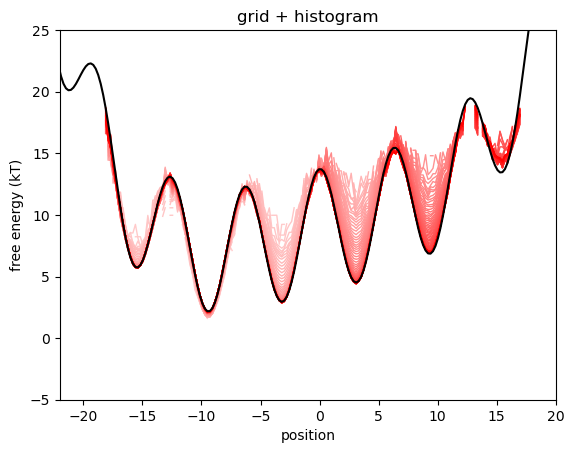

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:77: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(populations)


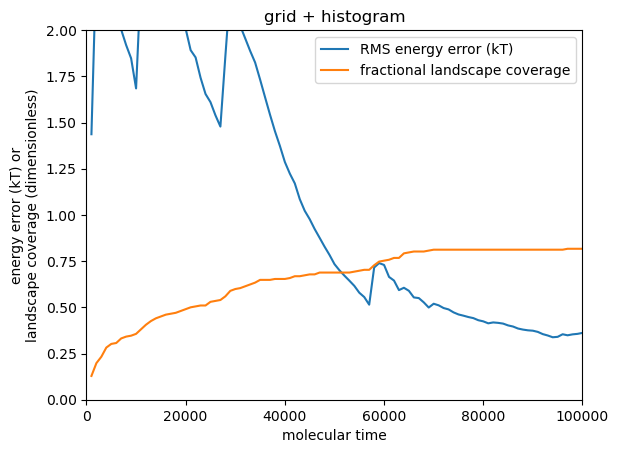

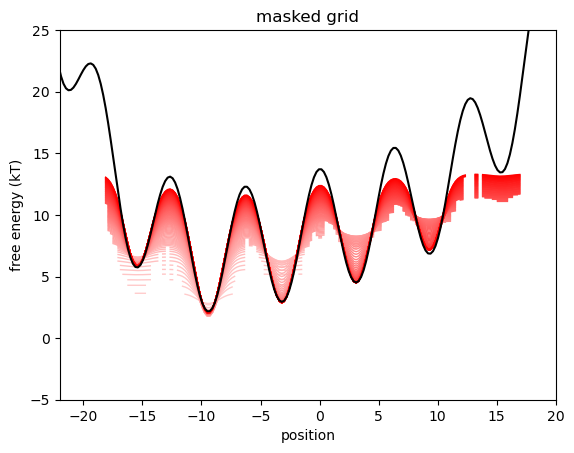

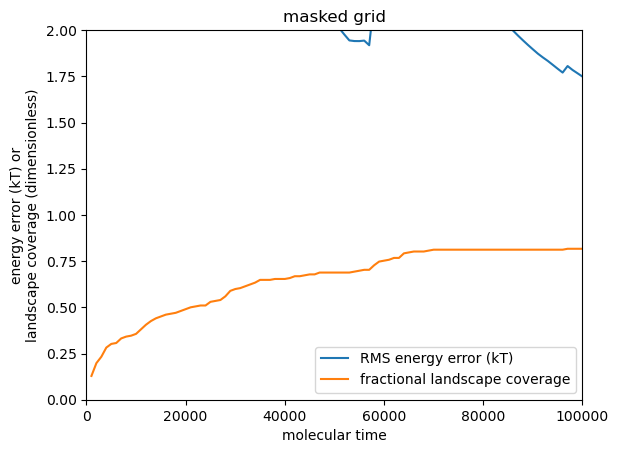

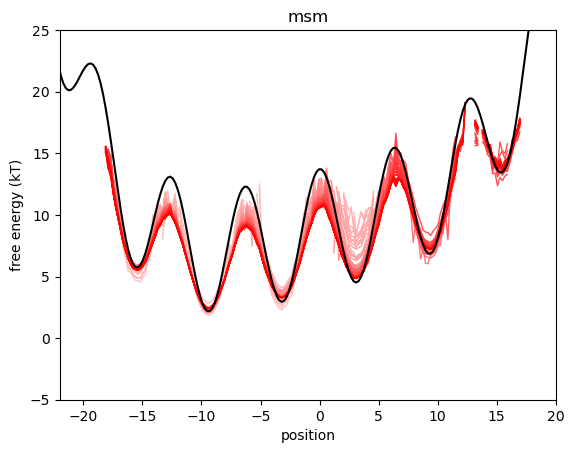

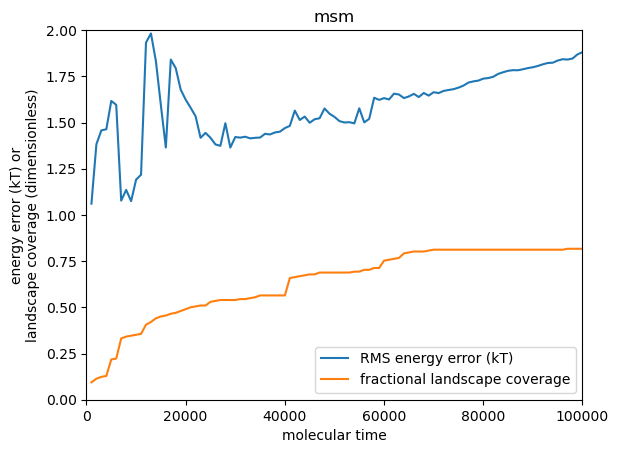

bootstrap round 2



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 256 parallel multiple walker metadynamics simulations
molecular time: 100000 steps;  aggregate time: 25600000 steps
data points saved: 256000 at 100-step intervals
gaussians of height 0.000390625 are added every 100 steps
9.999999999999964 of 100
0.003906249999999986
20.000000000000004of 100
0.003906250000000001
30.000000000000192of 100
0.003906250000000025
40.00000000000024 of 100
0.003906250000000023
50.000000000000426of 100
0.003906250000000033
60.00000000000066 of 100
0.003906250000000039
70.00000000000074 of 100
0.003906250000000042
80.00000000000087 of 100
0.0039062500000000425
90.00000000000097 of 100
0.003906250000000042
100.00000000000130 of 100
0.00390625000000005
110.00000000000139 of 100
0.0039062500000000494
120.00000000000107 of 100
0.003906250000000035
130.00000000000088 of 100
0.003906250000000027
140.00000000000102 of 100
0.003906250000000029
150.00000000000142 of 100
0.

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:66: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(observable)


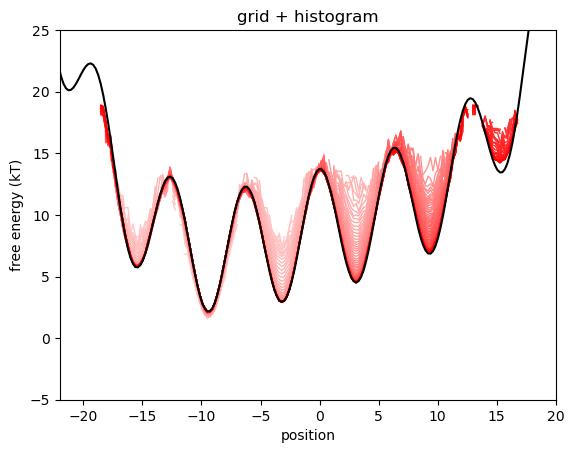

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:77: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(populations)


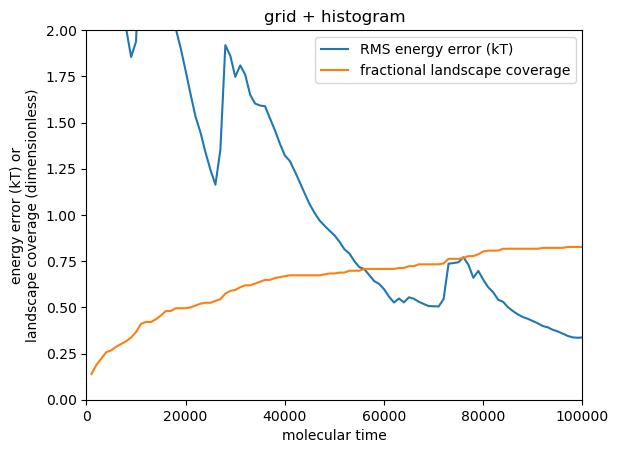

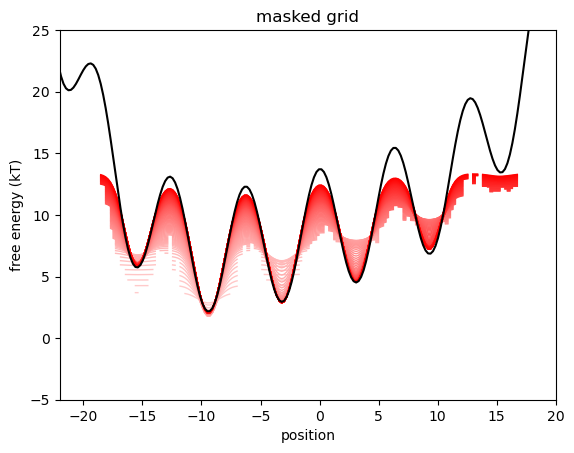

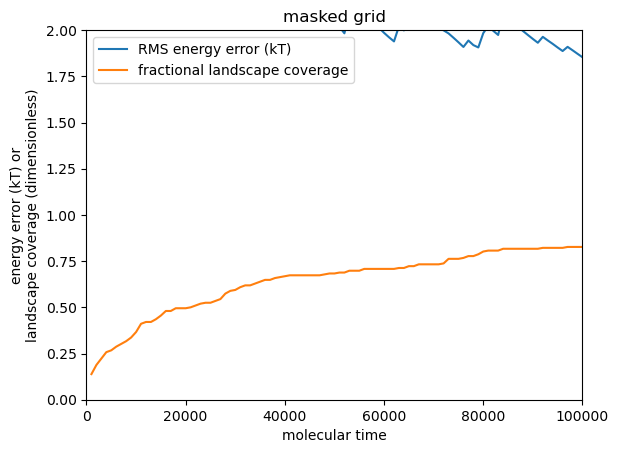

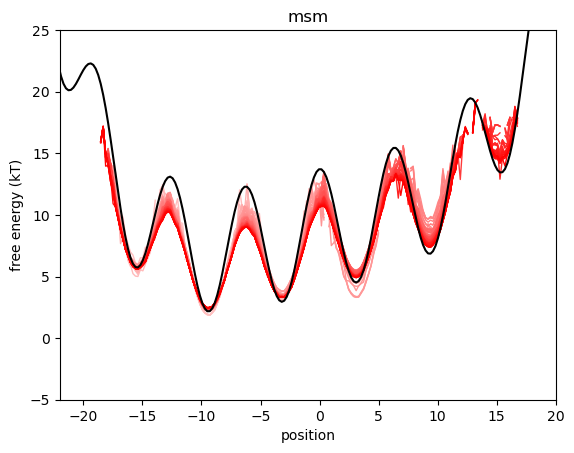

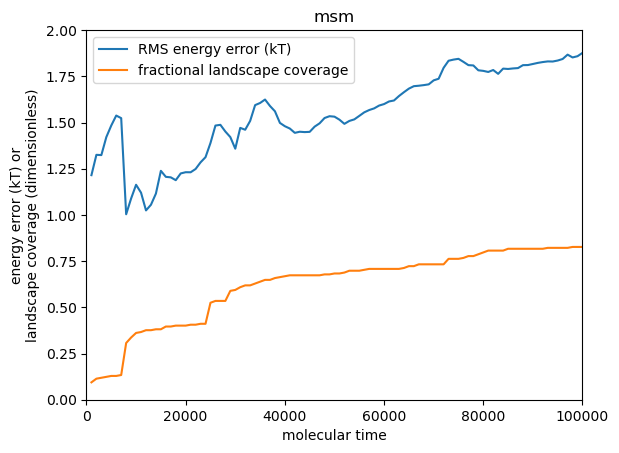

bootstrap round 3



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 256 parallel multiple walker metadynamics simulations
molecular time: 100000 steps;  aggregate time: 25600000 steps
data points saved: 256000 at 100-step intervals
gaussians of height 0.000390625 are added every 100 steps
9.999999999999952 of 100
0.0039062499999999814
20.00000000000002 of 100
0.003906250000000004
29.999999999999815of 100
0.003906249999999976
39.99999999999974 of 100
0.003906249999999971
49.99999999999995 of 100
0.003906249999999992
59.99999999999993 of 100
0.0039062499999999952
69.99999999999983 of 100
0.0039062499999999905
80.00000000000048 of 100
0.003906250000000019
90.00000000000048 of 100
0.003906250000000021
100.00000000000016 of 100
0.003906250000000006
110.00000000000036 of 100
0.003906250000000013
119.99999999999979 of 100
0.003906249999999993
129.99999999999932 of 100
0.0039062499999999796
139.99999999999952 of 100
0.0039062499999999866
149.99999999999865 of 10

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:66: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(observable)


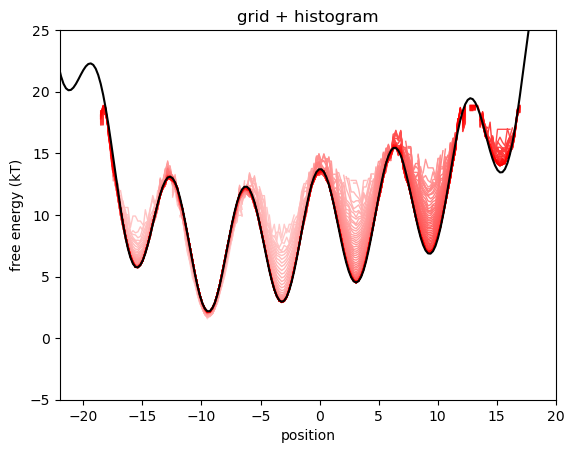

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:77: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(populations)


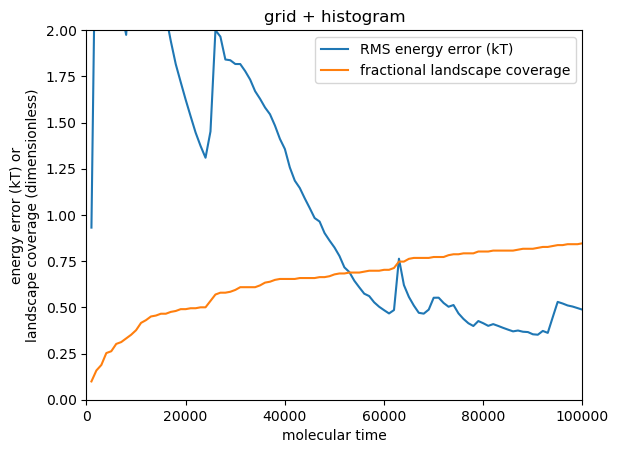

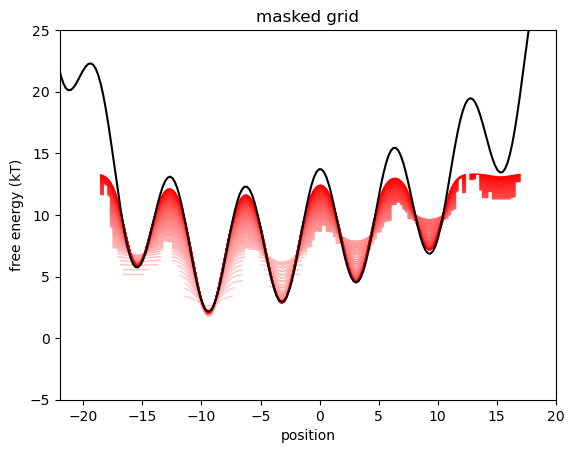

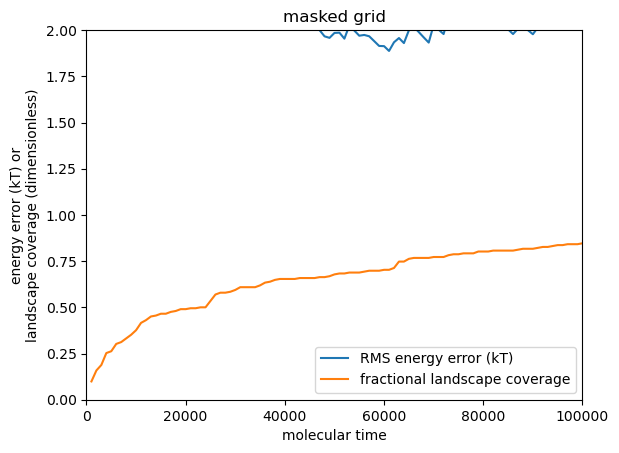

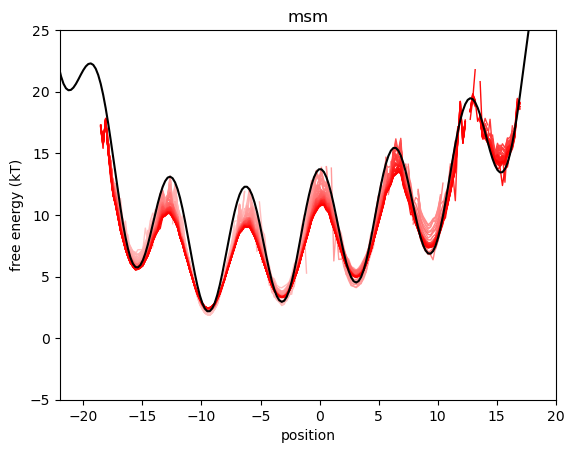

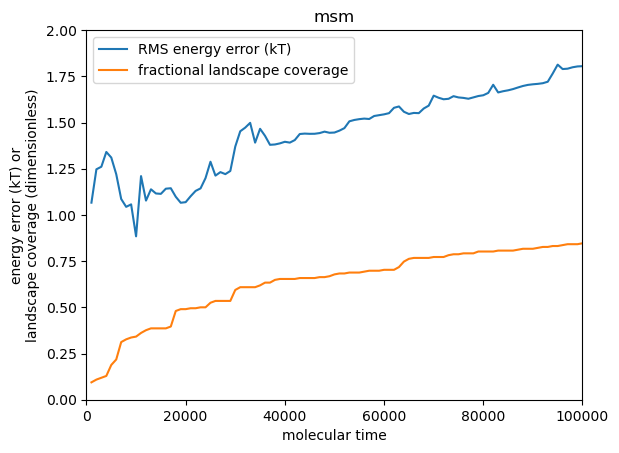

bootstrap round 4



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 256 parallel multiple walker metadynamics simulations
molecular time: 100000 steps;  aggregate time: 25600000 steps
data points saved: 256000 at 100-step intervals
gaussians of height 0.000390625 are added every 100 steps
9.999999999999993 of 100
0.0039062499999999974
20.0ing segment 2 of 100
0.00390625
30.000000000000064of 100
0.003906250000000009
40.00000000000003 of 100
0.003906250000000003
50.0ing segment 5 of 100
0.00390625
60.00000000000003 of 100
0.003906250000000002
69.99999999999999 of 100
0.003906249999999999
80.00000000000014 of 100
0.003906250000000007
89.99999999999939 of 100
0.0039062499999999735
99.999999999999610 of 100
0.0039062499999999844
109.99999999999971 of 100
0.0039062499999999896
120.00000000000009 of 100
0.003906250000000003
130.00000000000063 of 100
0.003906250000000018
140.00000000000136 of 100
0.003906250000000038
150.00000000000035 of 100
0.00390625000000000

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:66: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(observable)


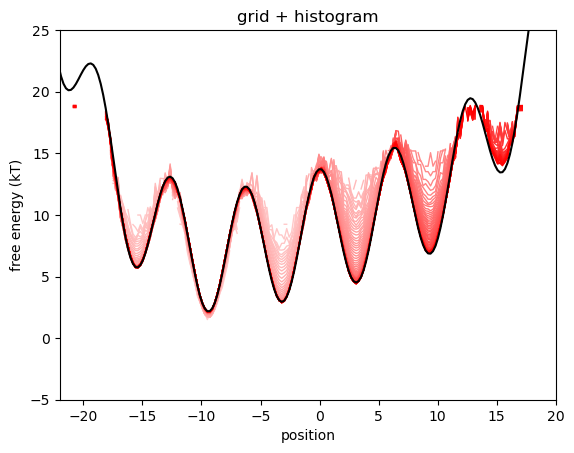

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:77: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(populations)


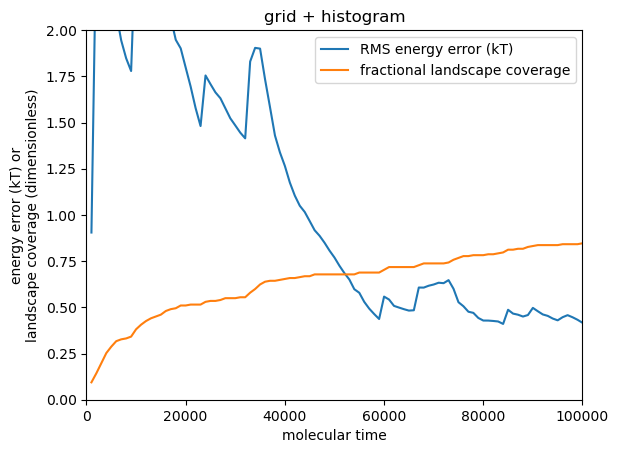

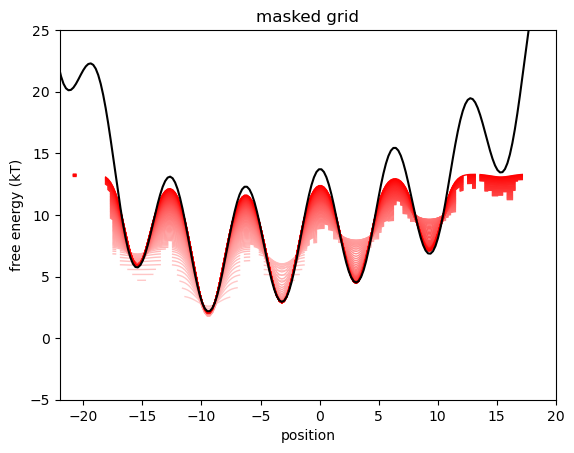

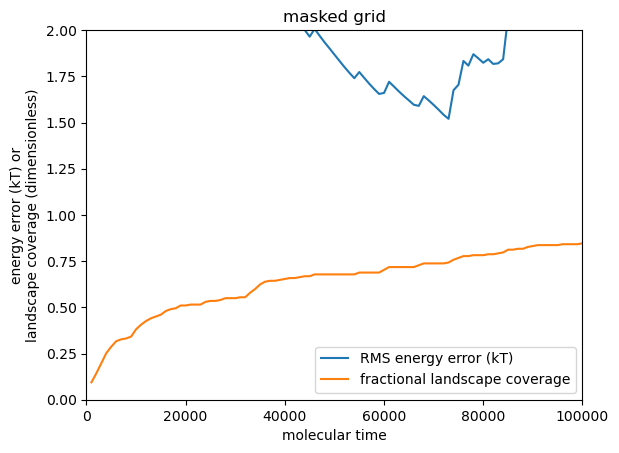

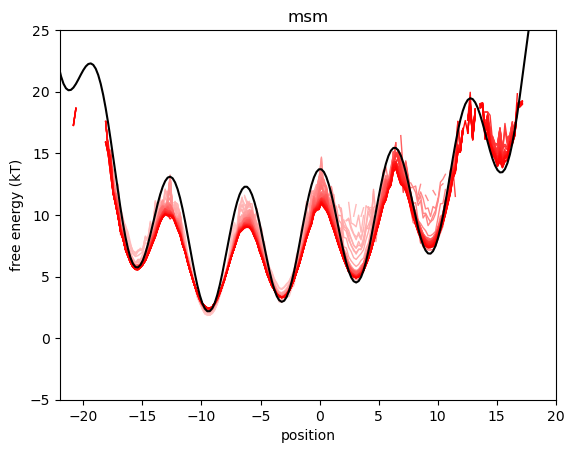

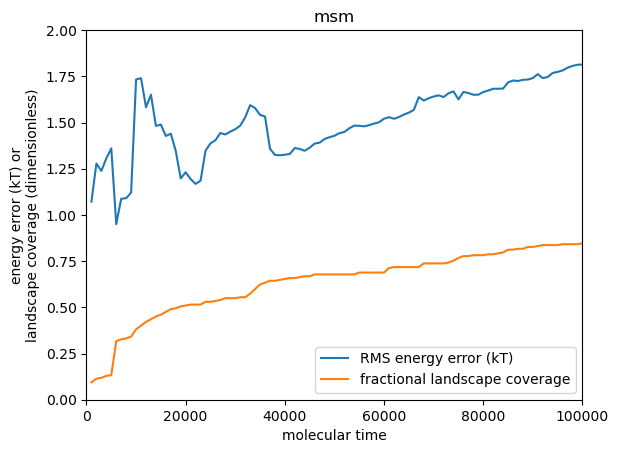

bootstrap round 5



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 256 parallel multiple walker metadynamics simulations
molecular time: 100000 steps;  aggregate time: 25600000 steps
data points saved: 256000 at 100-step intervals
gaussians of height 0.000390625 are added every 100 steps
9.999999999999971 of 100
0.0039062499999999883
20.00000000000001 of 100
0.003906250000000002
30.000000000000135of 100
0.003906250000000017
40.00000000000014 of 100
0.003906250000000014
50.000000000000036of 100
0.003906250000000003
60.00000000000001 of 100
0.003906250000000001
69.99999999999983 of 100
0.0039062499999999905
79.99999999999978 of 100
0.0039062499999999853
89.99999999999949 of 100
0.003906249999999978
99.999999999999630 of 100
0.0039062499999999857
110.00000000000017 of 100
0.003906250000000006
120.00000000000032 of 100
0.0039062500000000095
130.00000000000073 of 100
0.003906250000000022
139.99999999999923 of 100
0.0039062499999999787
149.99999999999918 of 1

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:66: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(observable)


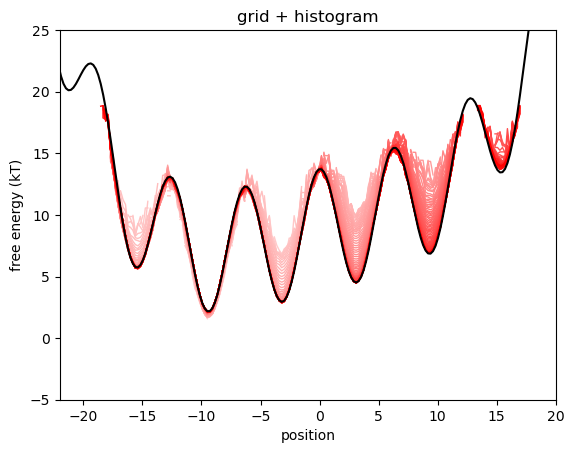

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/utility_v1.py:77: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(populations)


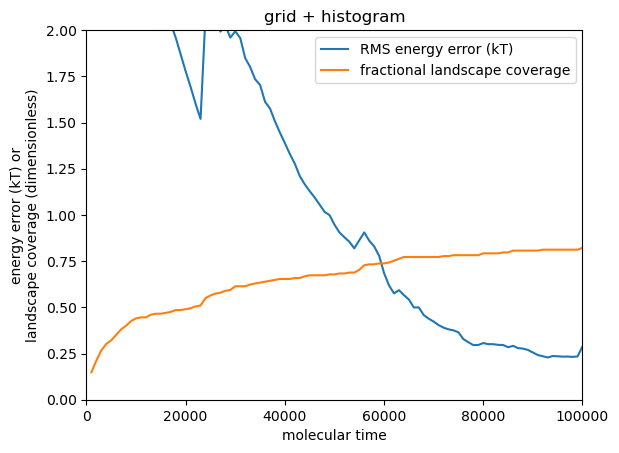

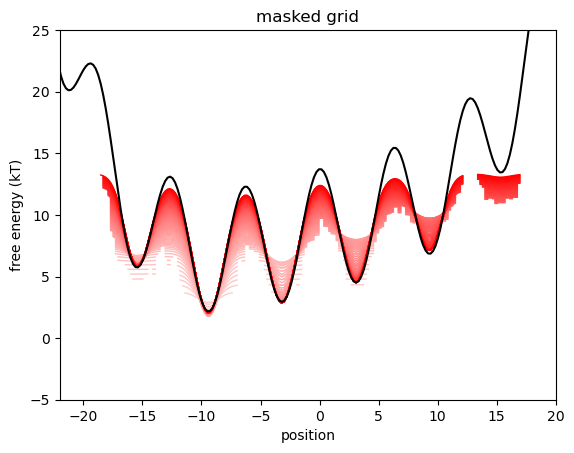

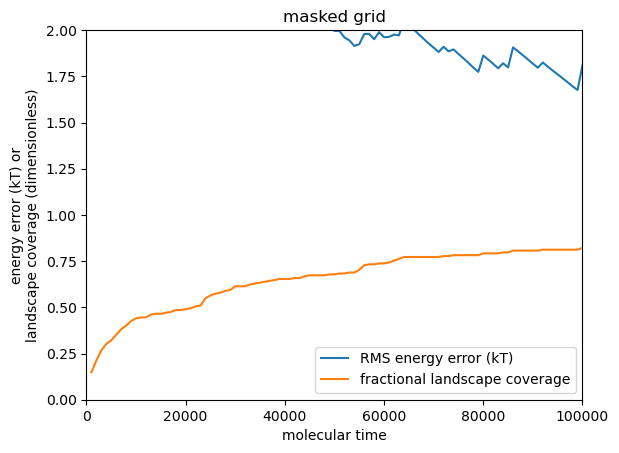

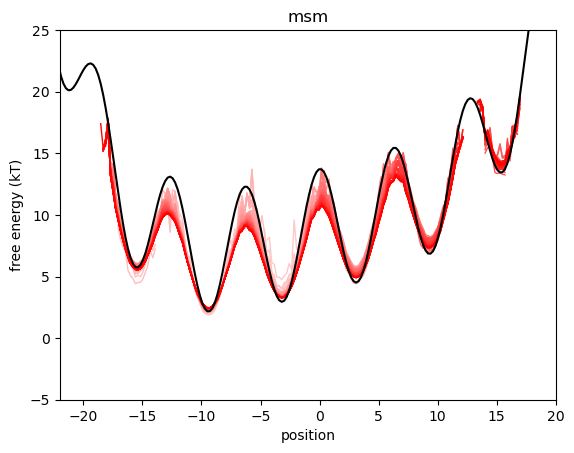

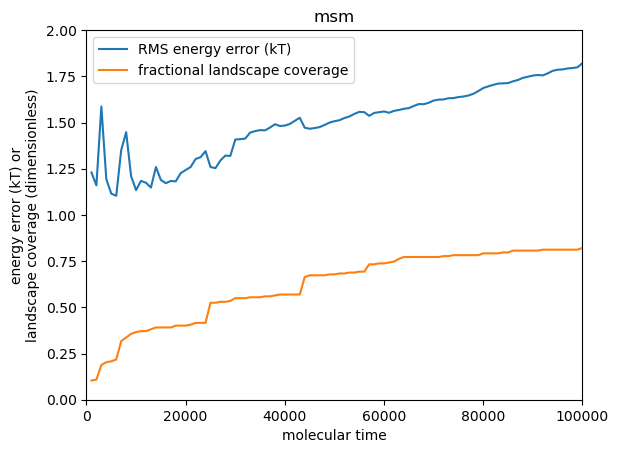

IndexError: list assignment index out of range

In [16]:
importlib.reload(utility_v1)
importlib.reload(propagators_v2)
importlib.reload(energy_landscapes_v1)
importlib.reload(MSM_methods)

importlib.reload(parallel_simulations_v2)
importlib.reload(weighted_ensemble_v2)
importlib.reload(metadynamics_v1)
importlib.reload(multiple_walker_metadynamics_v2)
importlib.reload(we_mtd_v1)

importlib.reload(visualization_v1)

#------------------------------system----------------------------------
system1 = energy_landscapes_v1.deep_sine_well()
# system1.plot_quantity(system1.potential)
# system1.plot_quantity(system1.F)
# plt.show()

kT = 1     #Boltzmann factor
dt = 0.01  #integration timestep

#TODO make the parameters below and system (and method hyperparams) into a TEST_SETUP object so we can reproduce ones that worked well
#hyperparameters for estimating convergence
n_timepoints = 100
n_bootstrap = 5

#binning parameters
n_analysis_bins = 200
#save frequency

#simulation time limits (integration steps)
#aggregate_simulation_limit = 2420000 #150000000

#number of parallel simulations that are run at a time.
#this is the maximum number in the case of WE simulations.
# If a WE run requires more than this number of this walkers per WE round, 
# they would have to be run serially and the WE round would 
# consume multiple WE round lengths worth of molecular time.
# the WE implementation in this sofware package does not actually do this under the hood, 
# but calculates how much molecular time would have been consumed if the WE run had been executed on n_parallel GPUs
n_parallel = 256

#note: system can diffuse to uniformly fill hexic well in 50k steps
#so sampling in simulations of at least that timescale is definitely limited by energy barriers rather than being diffusion-limited
#could set this time to equal the time it took 50% of walkers to diffuse across a flat landscape of width equal to the test landscape
molecular_time_limit = 100000 #400000 #20000
#how often the compute nodes or simulation processes can communicate
#really there should be some linear tradeoff (or tradeoff proportional to amount of data which needs to be communicated) between this and molecular_time_limit
min_communication_interval = 100 #simulation steps; current value is probably outlandishly short
#this could be made shorter but does not appear to be a limiting factor
min_frame_save_interval = min_communication_interval

#total amount of frames each method is allowed to save
#this does not appear to be a limiting factor
#frame_save_limit = 100000

#move the number of WE rounds out here; number of data points should be held constant across methods because it reflects lab storage capacity
#we_rounds_per_timepoint = 10 #convert to process communication frequency
#save_period = int(round(molecular_time_limit/(we_rounds_per_timepoint*n_timepoints))) #in steps

#define bins and calculate the true populations thereof
binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)

true_populations, true_energies = system1.normalized_pops_energies(kT, bincenters)

system_args = system1, kT, dt
resource_args = n_parallel, molecular_time_limit, min_communication_interval, min_frame_save_interval
bin_args = n_timepoints, n_analysis_bins, binbounds, bincenters
true_values = true_populations, true_energies

coverage_thresh = 0.5
RMS_energy_error_thresh = 1


n_samplers = 1

bs_times = [[] for _ in range(n_samplers)]

bs_mean_coverage = [[] for _ in range(n_samplers)]
bs_std_coverage = [[] for _ in range(n_samplers)]

bs_mean_error = [[] for _ in range(n_samplers)]
bs_std_error = [[] for _ in range(n_samplers)]

# j=0
# sampler_params_we_mtd = [4, n_analysis_bins, 10, [0.5], 0.001, 2, "we_mtd"]
# we_mtd_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, we_mtd_v1.sampler_we_mtd, sampler_params_we_mtd, true_values)

# j=1
# sampler_params_we = [4, n_analysis_bins, 2, "we"]
# we_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, weighted_ensemble_v2.sampler_we, sampler_params_we, true_values)

j=2
sampler_params_parallel_mwm = [10, [0.5], 0.001, 4, "mtd"]
parallel_mwm_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, multiple_walker_metadynamics_v2.sampler_parallel_hist_mtd, sampler_params_parallel_mwm, true_values)

# j=3
# sampler_params_parallel = [2, "parallel"]
# parallel_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, parallel_simulations_v2.sampler_parallel_hist, sampler_params_parallel, true_values)


legend = ["mwm+we msm", "we msm", "mwm grid+hist", "parallel msm"]


for j in range(n_samplers):
    plt.errorbar(bs_times[j][0], bs_mean_coverage[j][0], yerr=bs_std_coverage[j][0])

plt.title("coverage vs time")
plt.ylim(0,1)
plt.xlim(0, molecular_time_limit)

plt.xlabel("molecular time")
plt.ylabel("fractional coverage")
plt.legend(legend)

plt.savefig("figures/coverage_vs_time.png", format="png", dpi=600)
plt.show()


for j in range(n_samplers):
    plt.errorbar(bs_times[j][0], bs_mean_error[j][0], yerr=bs_std_error[j][0])

plt.title("error vs time")
plt.ylim(0,3)
plt.xlim(0, molecular_time_limit)

plt.xlabel("molecular time")
plt.ylabel("RMS energy (kT)")
plt.legend(legend)

plt.savefig("figures/error_vs_time.png", format="png", dpi=600)
plt.show()

#TODO figure out how to analyze convergence times if they're log-normally distributed


In [11]:
data = [[256000., 384000., 256000., 384000., 384000.],
        [128000., 256000., 256000., 256000., 256000.]]
#[[66560000., 30720000., 31744000., 60416000., 53248000.],
#        [32768000., 27648000., 31744000., 26624000., 33792000.]]

import scipy.stats as sps
result = sps.ttest_ind(data[0],data[1])

print(result)

TtestResult(statistic=2.529822128134703, pvalue=0.03526520347508, df=8.0)


In [12]:
#run sampling methods
#TODO write bootstrapper
#observables_parallel_mtd = multiple_walker_metadynamics_v1.sampler_parallel_hist_mtd(system1, aggregate_simulation_limit, molecular_time_limit, min_communication_interval, n_timepoints, kT, dt, binbounds, bincenters)
#observables_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, n_parallel, molecular_time_limit, min_frame_save_interval, n_timepoints, kT, dt, binbounds, bincenters)
#observables_we = weighted_ensemble_v1.sampler_we_hist(system1, aggregate_simulation_limit, molecular_time_limit, n_timepoints, min_communication_interval, kT, dt, binbounds)

#define which energy landscapes to plot based on the sampling methods and energy landscape estimation methods used
# landscape_estimates = [[observables_parallel[0], "parallel ; histogram"], 
#                        [observables_parallel[1], "parallel ; MSM"]]
# #                        [observables_we[0], "WE ; histogram"], 
# #                        [observables_we[1], "WE ; MSM"],

# # #                       [observables_parallel_mtd[0], "parallel MTD ; uncorrected grid"],
# # #                       [observables_parallel_mtd[1], "parallel MTD ; grid"],
# #                        [observables_parallel_mtd[4], "parallel MTD ; masked grid"],
# # #                       [observables_parallel_mtd[2], "parallel MTD ; histogram"],
# #                        [observables_parallel_mtd[3], "parallel MTD ; grid+histogram"]]
                       


# #----------------------------------------------------PLOT RESULTS----------------------------------------------------
# #TODO make this into its own method since this notebook cell is getting too long

# landscape_estimates_plot = landscape_estimates

# observables_we = [] #dummy value; comment when running WE
# #TODO refactor plotting code so this isn't necessary

# #landscape estimates
# for le in landscape_estimates_plot:
#     visualization_v1.plot_landscape_estimates(le, observables_we, bincenters, kT, true_populations, true_energies, molecular_time_limit, aggregate_simulation_limit, min_communication_interval)

# #convergence over time
# visualization_v1.plot_convergence(landscape_estimates_plot, kT, true_populations, true_energies, molecular_time_limit, n_timepoints)


#TODO plot time of first sampling (done via imshow) and time of convergence to within 1 kT

In [13]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()